### 运行前先装一个PyEMD库     是pip install pyemd   还是pip install PyEMD ，pip install EMD-signal  还试着装哪个成功

In [7]:
# 调用相关库
import os

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
import pandas as pd
from math import sqrt
from numpy import concatenate
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
from scipy.io import savemat,loadmat
from keras.callbacks import LearningRateScheduler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from PyEMD import EMD,EEMD, Visualisation
from pandas import DataFrame
from pandas import concat
import keras.backend as K
import numpy
import os
from sklearn.neural_network import MLPRegressor 

In [2]:
# 转换成监督数据，将每个特征转换成21列数据，20->1，20组预测一组
def series_to_supervised(data, n_in=20, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]  #计算特征的数量
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    # 将20组输入数据依次向下移动20,19,...3,2,1行，将数据加入cols列表（技巧：(n_in, 0, -1)中的-1指倒序循环，步长为1）
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    # 将一组输出数据加入cols列表（技巧：其中i=0）
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # cols列表(list)中现在有21块经过下移后的数据(即：df(-20),df(-19),...df(-2),df(-1),df)，将四块数据按列 并排合并
    agg = pd.concat(cols, axis=1)
    # 给合并后的数据添加列名
    agg.columns = names
    # print(agg)
    # 删除NaN值列
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [3]:
values=pd.read_csv('train.csv').values[:5000,-1]
# values
# dates=df.index.values
n_features=1 #特征数量

In [4]:
values = values.astype('float32')
close = values

In [5]:
close=close.reshape(-1,1)
close.shape

(5000, 1)

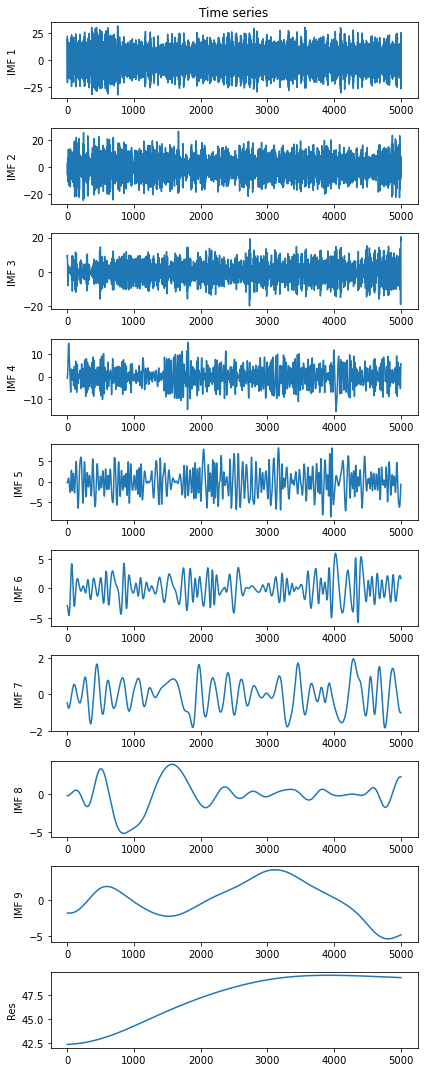

In [6]:
emd = EMD()   
emd.emd(close.reshape(-1))
imfs_close, res_close = emd.get_imfs_and_residue()

t = np.arange(0, 5000, 1)
vis = Visualisation()
vis.plot_imfs(imfs=imfs_close, residue=res_close, t=t, include_residue=True)
# vis.plot_instant_freq(t, imfs=imfs)
vis.show()

In [8]:
svr = []
prediction_test = []
actual_test = []

i = 1
svr = []
prediction_test = []
actual_test = []

for imf in imfs_close:
    imf=imf.reshape(-1,1)
    imf=pd.DataFrame(imf)
    data_=imf.values
    data_ = data_.astype('float32')
    # 标准化
    scaler =StandardScaler()
    scaled = scaler.fit_transform(data_)
    
    # 构建成监督学习问题
    n_in=3
    n_out=1
    n_vars=1
# 构建成监督学习问题
    reframed = series_to_supervised(scaled, n_in, n_out)  # 预测时间步长为15 ，输出时间步1  ，即由t-15,t-14,....t-1预测t
    values_ = reframed.values 
    ratio=0.8 #训练集和测试集的划分比例
    N=int(len(values_) *ratio)
    train = values_[:N, :]
    test = values_[N:, :]
    # 把数据分为输入和输出
    train_X, train_y = train[:, :-1], train[:, -1]
    test_X, test_y = test[:, :-1], test[:, -1]
    
    
    tmp = MLPRegressor(hidden_layer_sizes=(50),  max_iter=80, random_state=10,verbose=2)  # BP神经网络回归模型
    tmp = tmp.fit(train_X,train_y)  # 训练模型
    svr.append(tmp)

    
    
    #预测
    yhat = tmp.predict(test_X)
    yhat=yhat.reshape(-1,1)
    # 对预测结果进行反归一化
    inv_yhat = scaler.inverse_transform(yhat)
    prediction_test.append(inv_yhat)
    # 将真实列据进行反归一化
    test_y=test_y.reshape(-1,1)
    inv_y = scaler.inverse_transform(test_y)
    actual_test.append(inv_y)

    





#####残差
imf=res_close.reshape(-1,1)
imf=pd.DataFrame(imf)
data_=imf.values
data_ = data_.astype('float32')
# 标准化
scaler =StandardScaler()
scaled = scaler.fit_transform(data_)
    
# 构建成监督学习问题
n_in=3
n_out=1
n_vars=1
# 构建成监督学习问题
reframed = series_to_supervised(scaled, n_in, n_out)  # 预测时间步长为15 ，输出时间步1  ，即由t-15,t-14,....t-1预测t
values_ = reframed.values 
ratio=0.8 #训练集和测试集的划分比例
N=int(len(values_) *ratio)
train = values_[:N, :]
test = values_[N:, :]
# 把数据分为输入和输出
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
    
    
tmp = MLPRegressor(hidden_layer_sizes=(50),  max_iter=80, random_state=10,verbose=2)  # BP神经网络回归模型
tmp = tmp.fit(train_X,train_y)  # 训练模型
svr.append(tmp)
    

    
    
    
#预测
yhat = tmp.predict(test_X)
yhat=yhat.reshape(-1,1)
# 对预测结果进行反归一化
inv_yhat = scaler.inverse_transform(yhat)
prediction_test.append(inv_yhat)
# 将真实列据进行反归一化
test_y=test_y.reshape(-1,1)
inv_y = scaler.inverse_transform(test_y)
actual_test.append(inv_y)



Iteration 1, loss = 0.49776387
Iteration 2, loss = 0.44056685
Iteration 3, loss = 0.41236154
Iteration 4, loss = 0.39801438
Iteration 5, loss = 0.39012946
Iteration 6, loss = 0.38491947
Iteration 7, loss = 0.38116956
Iteration 8, loss = 0.37786096
Iteration 9, loss = 0.37550032
Iteration 10, loss = 0.37257568
Iteration 11, loss = 0.37025641
Iteration 12, loss = 0.36832735
Iteration 13, loss = 0.36604428
Iteration 14, loss = 0.36412545
Iteration 15, loss = 0.36234548
Iteration 16, loss = 0.36050242
Iteration 17, loss = 0.35877500
Iteration 18, loss = 0.35692474
Iteration 19, loss = 0.35522456
Iteration 20, loss = 0.35421489
Iteration 21, loss = 0.35250639
Iteration 22, loss = 0.35139223
Iteration 23, loss = 0.34975166
Iteration 24, loss = 0.34873552
Iteration 25, loss = 0.34744240
Iteration 26, loss = 0.34601510
Iteration 27, loss = 0.34529918
Iteration 28, loss = 0.34378501
Iteration 29, loss = 0.34269329
Iteration 30, loss = 0.34167140
Iteration 31, loss = 0.34067649
Iteration 32, los

C:\Users\lenovo\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (80) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 18, loss = 0.14467197
Iteration 19, loss = 0.14282904
Iteration 20, loss = 0.14164751
Iteration 21, loss = 0.14036662
Iteration 22, loss = 0.13924778
Iteration 23, loss = 0.13825564
Iteration 24, loss = 0.13701420
Iteration 25, loss = 0.13630136
Iteration 26, loss = 0.13535612
Iteration 27, loss = 0.13462631
Iteration 28, loss = 0.13363233
Iteration 29, loss = 0.13288000
Iteration 30, loss = 0.13224335
Iteration 31, loss = 0.13148146
Iteration 32, loss = 0.13075299
Iteration 33, loss = 0.13016236
Iteration 34, loss = 0.12935088
Iteration 35, loss = 0.12891106
Iteration 36, loss = 0.12811549
Iteration 37, loss = 0.12763248
Iteration 38, loss = 0.12723865
Iteration 39, loss = 0.12666353
Iteration 40, loss = 0.12613102
Iteration 41, loss = 0.12547248
Iteration 42, loss = 0.12513417
Iteration 43, loss = 0.12504403
Iteration 44, loss = 0.12430503
Iteration 45, loss = 0.12370819
Iteration 46, loss = 0.12315698
Iteration 47, loss = 0.12274934
Iteration 48, loss = 0.12241074
Iteratio

C:\Users\lenovo\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (80) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 28, loss = 0.01925804
Iteration 29, loss = 0.01855180
Iteration 30, loss = 0.01778121
Iteration 31, loss = 0.01704061
Iteration 32, loss = 0.01634134
Iteration 33, loss = 0.01567261
Iteration 34, loss = 0.01498778
Iteration 35, loss = 0.01432306
Iteration 36, loss = 0.01374725
Iteration 37, loss = 0.01308615
Iteration 38, loss = 0.01254129
Iteration 39, loss = 0.01196622
Iteration 40, loss = 0.01140709
Iteration 41, loss = 0.01092606
Iteration 42, loss = 0.01048405
Iteration 43, loss = 0.01006782
Iteration 44, loss = 0.00968626
Iteration 45, loss = 0.00931938
Iteration 46, loss = 0.00898017
Iteration 47, loss = 0.00872061
Iteration 48, loss = 0.00843936
Iteration 49, loss = 0.00821623
Iteration 50, loss = 0.00799334
Iteration 51, loss = 0.00781099
Iteration 52, loss = 0.00760741
Iteration 53, loss = 0.00746591
Iteration 54, loss = 0.00731920
Iteration 55, loss = 0.00720127
Iteration 56, loss = 0.00709845
Iteration 57, loss = 0.00703826
Iteration 58, loss = 0.00697847
Iteratio

In [9]:
mean_pre_test = []                    

for i in range(0,len(prediction_test[0])):
    sum = 0
    for j in range(0,len(prediction_test)):
        sum = sum + prediction_test[j][i]
    
#     mean = sum/len(prediction_test) 
    mean_pre_test.append(sum)
        
mean_pre_test        

[array([55.991062], dtype=float32),
 array([39.208065], dtype=float32),
 array([38.058964], dtype=float32),
 array([39.143074], dtype=float32),
 array([70.745636], dtype=float32),
 array([72.74069], dtype=float32),
 array([53.45332], dtype=float32),
 array([71.48139], dtype=float32),
 array([54.734627], dtype=float32),
 array([43.7042], dtype=float32),
 array([45.79283], dtype=float32),
 array([47.271473], dtype=float32),
 array([48.339985], dtype=float32),
 array([53.862724], dtype=float32),
 array([49.70876], dtype=float32),
 array([33.641846], dtype=float32),
 array([32.6845], dtype=float32),
 array([34.36718], dtype=float32),
 array([33.929817], dtype=float32),
 array([23.138737], dtype=float32),
 array([47.3834], dtype=float32),
 array([50.14305], dtype=float32),
 array([58.49245], dtype=float32),
 array([63.3199], dtype=float32),
 array([54.636375], dtype=float32),
 array([63.396408], dtype=float32),
 array([32.172207], dtype=float32),
 array([65.856705], dtype=float32),
 array([

In [10]:
mean_actual_test = []

for i in range(0,len(actual_test[0])):
    sum = 0
    for j in range(0,len(actual_test)):
        sum = sum + actual_test[j][i]
    
#     mean = sum/len(actual_test)
    mean_actual_test.append(sum)
        
mean_actual_test    

[array([68.], dtype=float32),
 array([61.], dtype=float32),
 array([25.], dtype=float32),
 array([66.], dtype=float32),
 array([61.], dtype=float32),
 array([72.], dtype=float32),
 array([50.], dtype=float32),
 array([79.], dtype=float32),
 array([74.], dtype=float32),
 array([42.], dtype=float32),
 array([22.], dtype=float32),
 array([29.], dtype=float32),
 array([33.], dtype=float32),
 array([34.], dtype=float32),
 array([48.], dtype=float32),
 array([52.], dtype=float32),
 array([67.], dtype=float32),
 array([61.], dtype=float32),
 array([37.], dtype=float32),
 array([21.000002], dtype=float32),
 array([66.], dtype=float32),
 array([45.], dtype=float32),
 array([56.], dtype=float32),
 array([70.], dtype=float32),
 array([48.], dtype=float32),
 array([57.], dtype=float32),
 array([24.], dtype=float32),
 array([76.], dtype=float32),
 array([21.000004], dtype=float32),
 array([32.], dtype=float32),
 array([30.], dtype=float32),
 array([27.999998], dtype=float32),
 array([49.], dtype=fl

In [11]:
# 计算RMSE
rmse = sqrt(mean_squared_error(mean_actual_test, mean_pre_test))
print('Test RMSE: %.7f' % rmse)
print('Test MAE: %.7f' % mean_absolute_error(mean_actual_test, mean_pre_test))
print('Test R2: %.7f' % r2_score(mean_actual_test, mean_pre_test))

Test RMSE: 9.7656797
Test MAE: 7.6142206
Test R2: 0.6127773


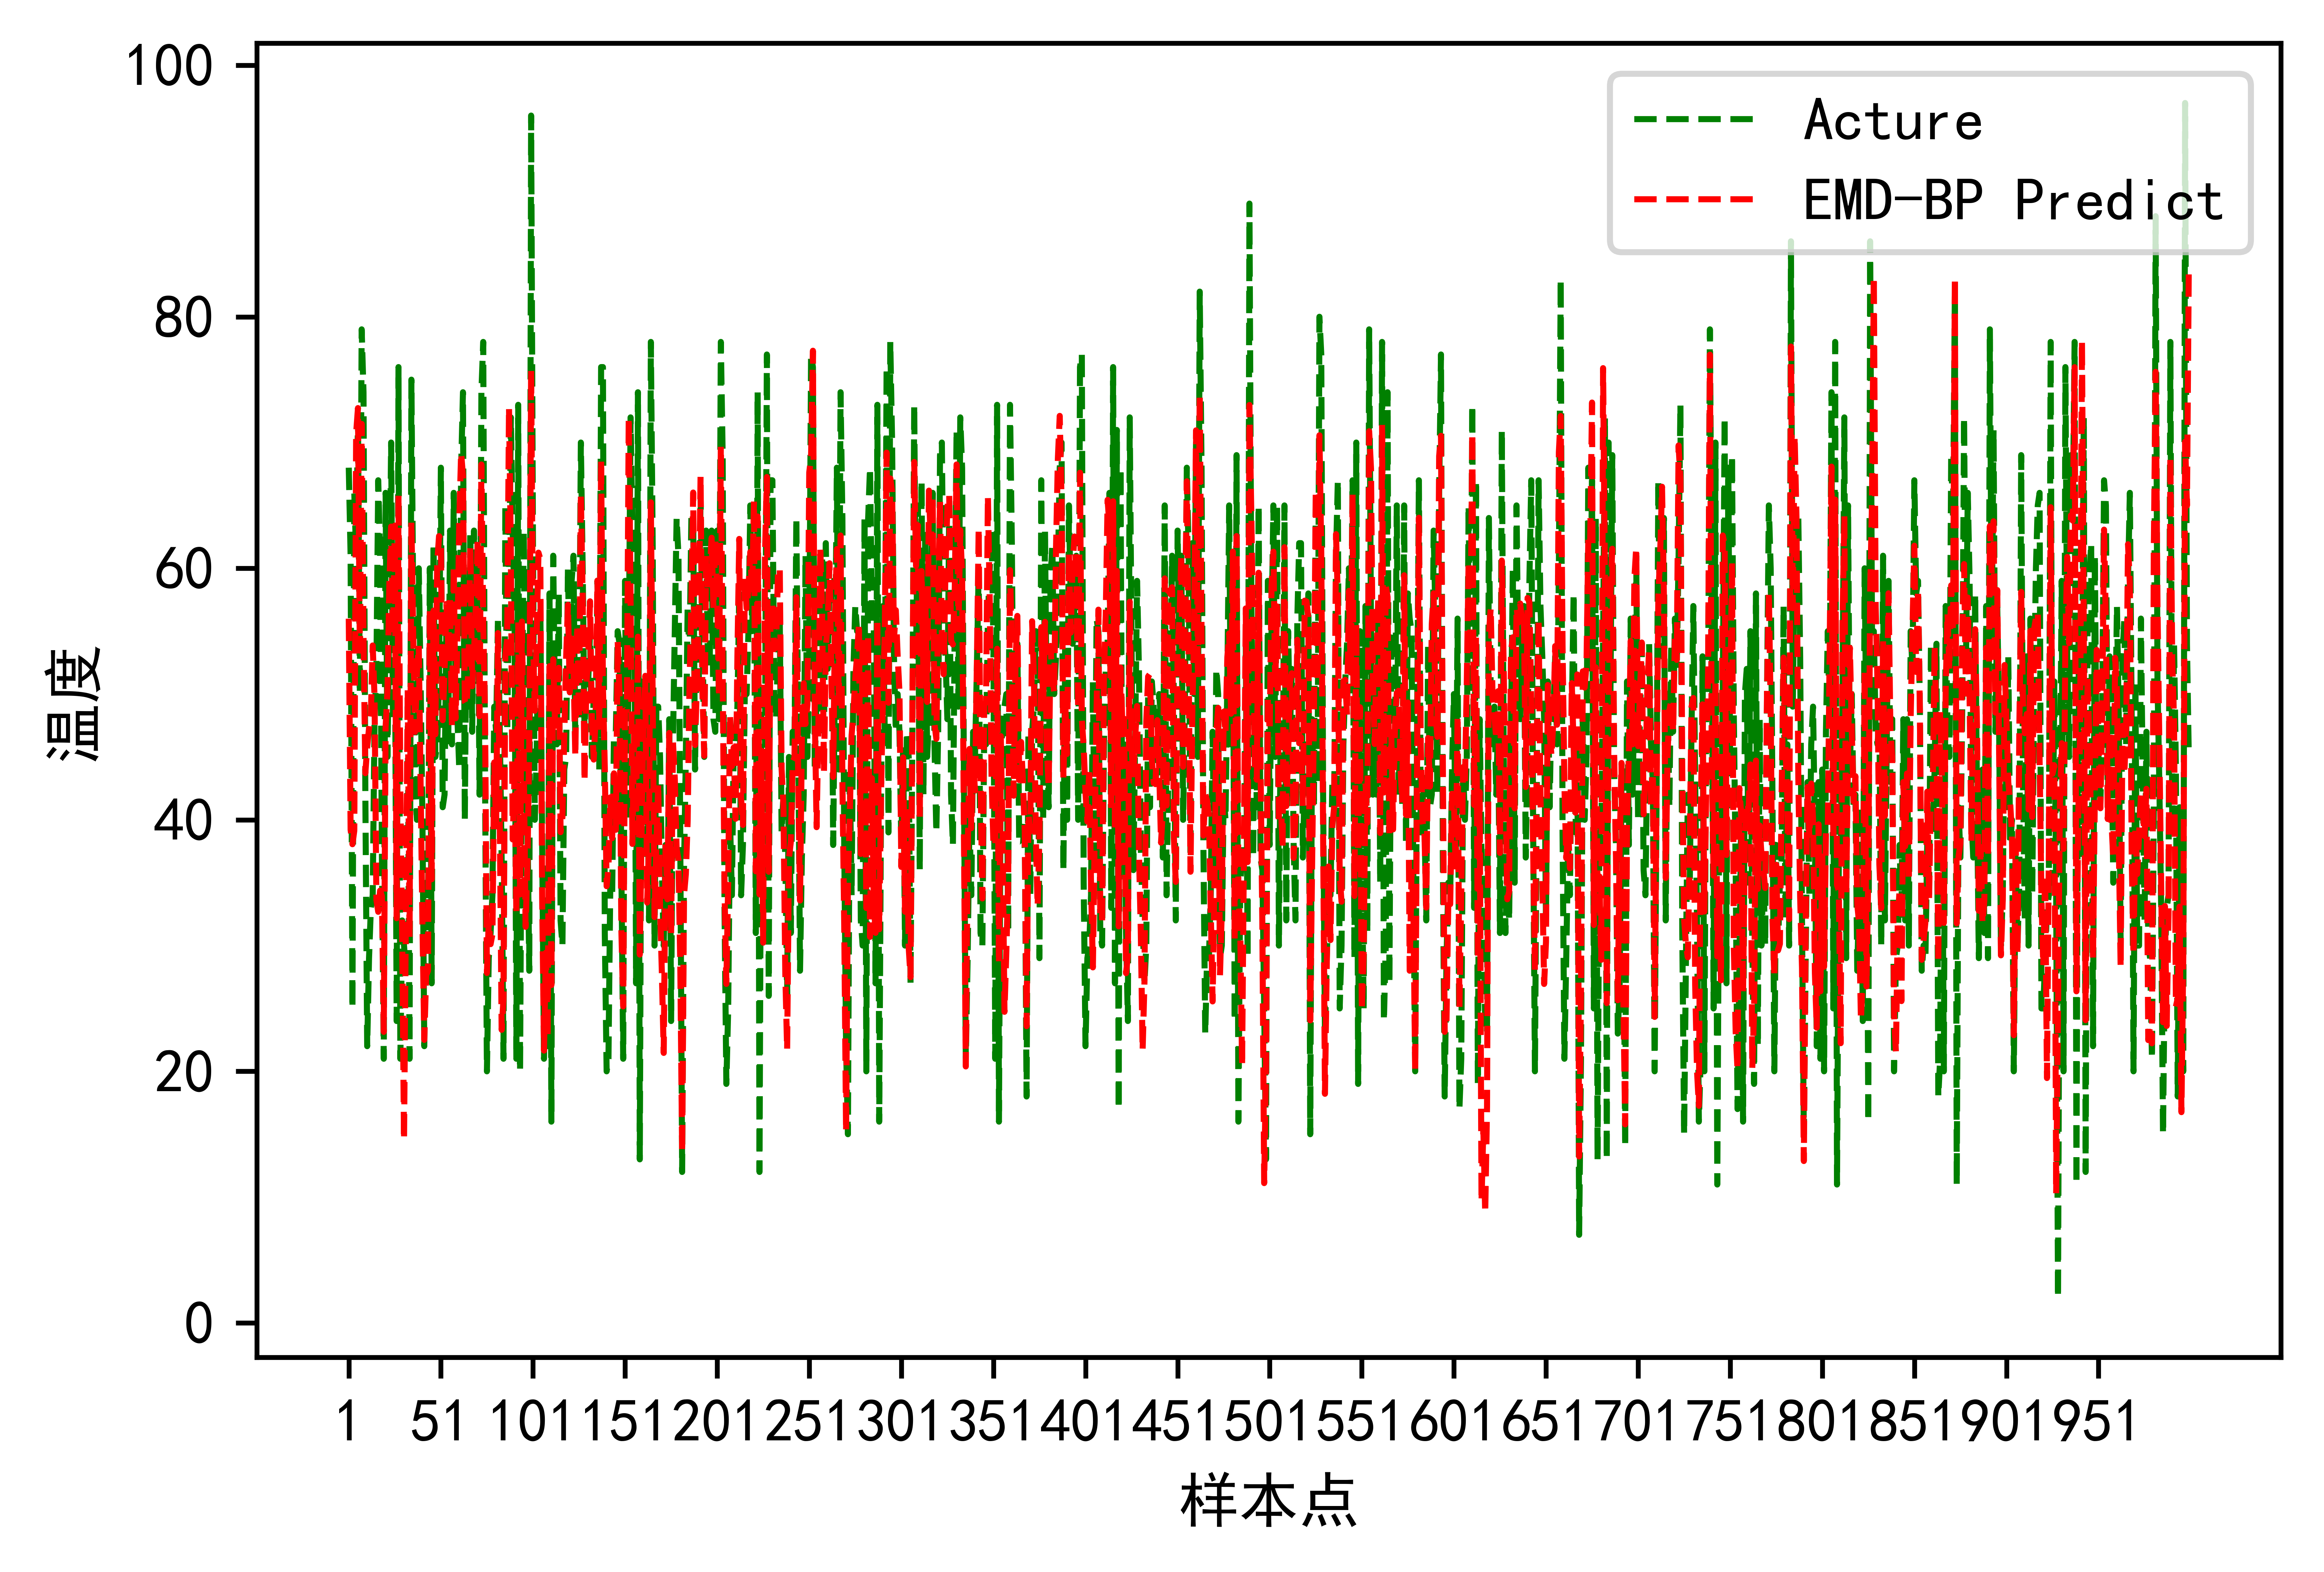

In [12]:
import seaborn as sns
%config InlineBackend.figure_format = 'retina'
plt.rcParams['font.sans-serif']=['Simhei']  #解决画图中文不显示问题
plt.figure(figsize=(6,4),dpi=600)
x=range(1, len(mean_pre_test) + 1)
plt.xticks(x[::50])
plt.tick_params(labelsize=10)  #改变刻度字体大小
plt.plot(x, mean_actual_test, linestyle="--",color='g',linewidth=1, label='Acture')
plt.plot(x, mean_pre_test,  color='red',linestyle="--",linewidth=1,label='EMD-BP Predict')
plt.rcParams.update({'font.size': 10})  #改变图例里面的字体大小
plt.legend(loc='upper right')
plt.xlabel("样本点",fontsize=10)
plt.ylabel("温度",fontsize=10)
# plt.xlim(xmin=600,xmax=700)  #显示600-1000的值   局部放大有利于观察
# plt.savefig('台湾VMD-LSTM震级预测结果图.png')
plt.show()

In [13]:
#保存预测结果
savemat('结果/emd-bp_result.mat',{'true':mean_actual_test,'pred':mean_pre_test})